In [1]:
import os
import random
import numpy as np
from PIL import Image
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset
from transformers import (
    AutoImageProcessor, 
    AutoModelForDepthEstimation, 
    TrainingArguments, 
    Trainer
)
from peft import LoraConfig, get_peft_model
import matplotlib.pyplot as plt

c:\Users\natha\Documents\Git\LoRA-Depth-Anything\env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class DepthDataset(Dataset):
    def __init__(self, pairs_list, images_path, depth_npy_path, image_processor):
        self.pairs_list = pairs_list
        self.images_path = images_path
        self.depth_npy_path = depth_npy_path
        self.image_processor = image_processor

    def __len__(self):
        return len(self.pairs_list)

    def __getitem__(self, idx):
        image_name, depth_npy_name = self.pairs_list[idx]
        
        image_file = os.path.join(self.images_path, image_name)
        depth_npy_file = os.path.join(self.depth_npy_path, depth_npy_name)
        
        image = Image.open(image_file).convert("RGB")
        depth_npy = np.load(depth_npy_file)
        
        # --- CORRECTION 1: GESTION DES CANAUX ---
        # Si l'image a 3 dimensions (H, W, C), on prend le canal Z
        if depth_npy.ndim == 3:
            # Vérifiez si Z est bien à l'index 2 (souvent 0 ou 2)
            # Une façon simple de savoir : le canal de profondeur a souvent la plus grande variance
            depth_npy = depth_npy[:, :, 2] 
            
        # --- CORRECTION 2: CONVERSION MM -> METRES (CRITIQUE) ---
        # Utiliser np.nanmax pour ignorer les NaNs qui cassent la condition
        # Si la valeur max est > 100 (ex: 2000mm), on convertit en mètres
        if np.nanmax(np.abs(depth_npy)) > 100:
            depth_npy = depth_npy / 1000.0
            
        # Nettoyage des valeurs aberrantes ou négatives résiduelles
        depth_npy[depth_npy < 0] = 0
        # Remplacer les NaNs par 0 ou une valeur ignorée
        depth_npy = np.nan_to_num(depth_npy, nan=0.0, posinf=0.0, neginf=0.0)

        inputs = self.image_processor(images=image, return_tensors="pt")
        
        # Création du tenseur
        depth_tensor = torch.from_numpy(depth_npy).float()
        # Ajout des dimensions pour l'interpolation (Batch, Channel, H, W)
        depth_tensor = depth_tensor.unsqueeze(0).unsqueeze(0)
        
        # Redimensionnement pour matcher l'entrée du modèle (souvent 518x518)
        target_size = inputs['pixel_values'].shape[-2:]
        depth_resized = F.interpolate(depth_tensor, size=target_size, mode='nearest')
        
        # On enlève les dimensions inutiles pour avoir (H, W)
        depth_resized = depth_resized.squeeze()

        return {
            'pixel_values': inputs['pixel_values'].squeeze(0),
            'labels': depth_resized,
            'image': image
        }

In [3]:
# 2. Chargement du Modèle et Processor
model_id = "depth-anything/Depth-Anything-V2-Small-hf"
image_processor = AutoImageProcessor.from_pretrained(model_id)
model = AutoModelForDepthEstimation.from_pretrained(model_id)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [4]:
# 4. Préparation des données (comme dans ton code original)
# Assure-toi que 'dataset' (ta classe DatasetImages) est bien instancié avant
dataset_path = "DATASET_DEVOIR"
images_path = os.path.join(dataset_path, "images")
depth_npy_path = os.path.join(dataset_path, "depth")
image_files = sorted(os.listdir(images_path))
depth_files = sorted(os.listdir(depth_npy_path))
# Filtrer pour s'assurer que les fichiers correspondent bien si nécessaire
all_pairs = list(zip(image_files, depth_files))
random.shuffle(all_pairs)

total = len(all_pairs)
train_split = int(0.7 * total)
eval_split = int(0.85 * total)

train_pairs = all_pairs[:train_split]
eval_pairs = all_pairs[train_split:eval_split]
test_pairs = all_pairs[eval_split:]

train_dataset = DepthDataset(train_pairs, images_path, depth_npy_path, image_processor)
eval_dataset = DepthDataset(eval_pairs, images_path, depth_npy_path, image_processor)
test_dataset = DepthDataset(test_pairs, images_path, depth_npy_path, image_processor)

In [5]:
# Afficher les noms de toutes les couches (modules) du modèle
print("Noms de toutes les couches du modèle :")
for name, module in model.named_modules():
    if name:  # Éviter la racine vide
        print(name)

Noms de toutes les couches du modèle :
backbone
backbone.embeddings
backbone.embeddings.patch_embeddings
backbone.embeddings.patch_embeddings.projection
backbone.embeddings.dropout
backbone.encoder
backbone.encoder.layer
backbone.encoder.layer.0
backbone.encoder.layer.0.norm1
backbone.encoder.layer.0.attention
backbone.encoder.layer.0.attention.attention
backbone.encoder.layer.0.attention.attention.query
backbone.encoder.layer.0.attention.attention.key
backbone.encoder.layer.0.attention.attention.value
backbone.encoder.layer.0.attention.output
backbone.encoder.layer.0.attention.output.dense
backbone.encoder.layer.0.attention.output.dropout
backbone.encoder.layer.0.layer_scale1
backbone.encoder.layer.0.drop_path
backbone.encoder.layer.0.norm2
backbone.encoder.layer.0.mlp
backbone.encoder.layer.0.mlp.fc1
backbone.encoder.layer.0.mlp.activation
backbone.encoder.layer.0.mlp.fc2
backbone.encoder.layer.0.layer_scale2
backbone.encoder.layer.1
backbone.encoder.layer.1.norm1
backbone.encoder.la

In [6]:
# 3. Configuration LoRA Correcte pour la Vision
# On cible tous les modules linéaires du Transformer pour un meilleur apprentissage
# On retire 'task_type' pour éviter l'erreur "input_ids"
lora_config = LoraConfig(
    r=64,
    lora_alpha=128,
    target_modules=["query", "key", "value", "dense", "fc1", "fc2"], 
    lora_dropout=0.05,
    bias="none",
)

In [7]:
lora_model = get_peft_model(model, lora_config)
lora_model.print_trainable_parameters()

trainable params: 5,308,416 || all params: 30,093,505 || trainable%: 17.6397


In [8]:
class DepthTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        predicted_depth = outputs.predicted_depth
        
        # 1. Interpolation
        if predicted_depth.shape[-2:] != labels.shape[-2:]:
            predicted_depth = F.interpolate(
                predicted_depth.unsqueeze(1), 
                size=labels.shape[-2:], 
                mode='bilinear', 
                align_corners=False
            ).squeeze(1)

        # --- CORRECTION ICI ---
        # Au lieu de Sigmoid (qui bloque le gradient), on utilise ReLU
        # Cela force juste les valeurs à être positives (Profondeur >= 0)
        predicted_depth = F.relu(predicted_depth) 

        # 2. Masque de validité
        # On garde les labels > 0 et on filtre les NaNs
        valid_mask = (labels > 0.001) & ~torch.isnan(labels)
        
        if valid_mask.sum() < 1:
            return torch.tensor(0.0, device=predicted_depth.device, requires_grad=True)

        pred_valid = predicted_depth[valid_mask]
        target_valid = labels[valid_mask]

        # 3. SiLog Loss (Scale Invariant)
        # Très robuste, elle gérera l'échelle même sans Sigmoid
        g = torch.log(pred_valid + 1e-6) - torch.log(target_valid + 1e-6)
        silog_loss = torch.mean(g ** 2) - 0.85 * (torch.mean(g) ** 2)
        
        # Petit ajout de L1 pour la précision
        l1_loss = F.l1_loss(pred_valid, target_valid)
        
        loss = 10.0 * silog_loss + 0.1 * l1_loss

        return (loss, outputs) if return_outputs else loss

In [9]:
args = TrainingArguments(
    output_dir="output_depth_lora",
    learning_rate=2e-4,
    lr_scheduler_type="cosine",
    warmup_ratio=0.1,
    weight_decay=0.01,
    
    # --- Optimisation pour RTX 3060 Laptop (6GB VRAM) ---
    per_device_train_batch_size=2,   # Réduit pour économiser la VRAM
    gradient_accumulation_steps=8,   # Augmenté pour garder un batch effectif de 16
    # ----------------------------------------------------
    
    num_train_epochs=30,             # Suffisant pour converger avec LoRA
    fp16=True,                       # Très important pour les cartes RTX (accélère et réduit la VRAM)
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    remove_unused_columns=False,
    label_names=["labels"]
)

In [10]:
# Fonction de collation simple
def collate_fn(batch):
    pixel_values = torch.stack([item['pixel_values'] for item in batch])
    labels = torch.stack([item['labels'] for item in batch])
    return {'pixel_values': pixel_values, 'labels': labels}

In [11]:
def compute_metrics(eval_pred):
    """
    Calcule les métriques de profondeur standards (Delta 1, AbsRel, RMSE).
    """
    predictions, labels = eval_pred
    
    # Si les prédictions ont une dimension de canal inutile (ex: B, 1, H, W), on l'enlève
    if predictions.ndim == 4:
        predictions = predictions.squeeze(1)
        
    # --- IMPORTANT : Appliquer la même logique que dans le Trainer ---
    # Si vous avez utilisé ReLU dans compute_loss, on fait pareil ici (max(0, x))
    predictions = np.maximum(predictions, 0)
    
    # Masque de validité (identique à celui de l'entraînement)
    # On ne note que sur les pixels où il y a une vraie mesure (> 0.001)
    # et on ignore les valeurs aberrantes du modèle (pour éviter les divisions par zéro)
    valid_mask = (labels > 0.001) & (labels < 100.0) & (predictions > 0.001)
    
    # On récupère seulement les pixels valides (aplatis en 1D)
    pred_valid = predictions[valid_mask]
    target_valid = labels[valid_mask]
    
    if len(target_valid) == 0:
        return {"delta1": 0.0, "abs_rel": 0.0, "rmse": 0.0}

    # --- CALCUL DE DELTA 1 ---
    # Formule : max(pred/target, target/pred) < 1.25
    thresh = np.maximum((target_valid / pred_valid), (pred_valid / target_valid))
    delta1 = (thresh < 1.25).mean()  # Pourcentage de pixels "bons"
    delta2 = (thresh < 1.25 ** 2).mean()
    delta3 = (thresh < 1.25 ** 3).mean()

    # --- AUTRES MÉTRIQUES UTILES ---
    # AbsRel : Erreur relative absolue moyenne (plus bas = mieux)
    abs_rel = np.mean(np.abs(pred_valid - target_valid) / target_valid)
    
    # RMSE : Racine de l'erreur quadratique moyenne (en mètres)
    rmse = np.sqrt(np.mean((pred_valid - target_valid) ** 2))

    return {
        "delta1": delta1,
        "delta2": delta2, 
        "delta3": delta3,
        "abs_rel": abs_rel,
        "rmse": rmse
    }

In [12]:
trainer = DepthTrainer(
    model=lora_model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,  # <--- AJOUTEZ CETTE LIGNE
)

trainer.train()

c:\Users\natha\Documents\Git\LoRA-Depth-Anything\env\Lib\site-packages\torch\nn\modules\module.py:1357: UserWarning: expandable_segments not supported on this platform (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\c10/cuda/CUDAAllocatorConfig.h:35.)
  return t.to(


Epoch,Training Loss,Validation Loss,Delta1,Delta2,Delta3,Abs Rel,Rmse
1,No log,6.970689,0.192742,0.322944,0.493136,1.014633,1.713921
2,No log,1.279287,0.269868,0.530481,0.827562,0.604880,0.963019
3,No log,0.677992,0.648833,0.940984,0.991251,0.204558,0.428169
4,No log,0.912398,0.322233,0.616490,0.959373,0.456845,0.727169
5,No log,0.600930,0.527729,0.875925,0.962709,0.211284,0.517035
6,No log,0.426061,0.806082,0.946354,0.978754,0.128491,0.362916
7,No log,0.422196,0.771212,0.941406,0.996778,0.162901,0.392504
8,No log,0.285951,0.902518,0.958140,0.999416,0.110261,0.288459
9,No log,0.272959,0.841091,0.958484,0.998994,0.113219,0.325612
10,No log,0.319804,0.843881,0.956569,0.998560,0.154231,0.332602


'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: baf21174-4f8b-4a16-a3ce-e920d46195d0)')' thrown while requesting HEAD https://huggingface.co/depth-anything/Depth-Anything-V2-Small-hf/resolve/main/config.json
Retrying in 1s [Retry 1/5].


TrainOutput(global_step=90, training_loss=0.5579881032307943, metrics={'train_runtime': 486.2959, 'train_samples_per_second': 2.468, 'train_steps_per_second': 0.185, 'total_flos': 2.8283657534496e+17, 'train_loss': 0.5579881032307943, 'epoch': 30.0})

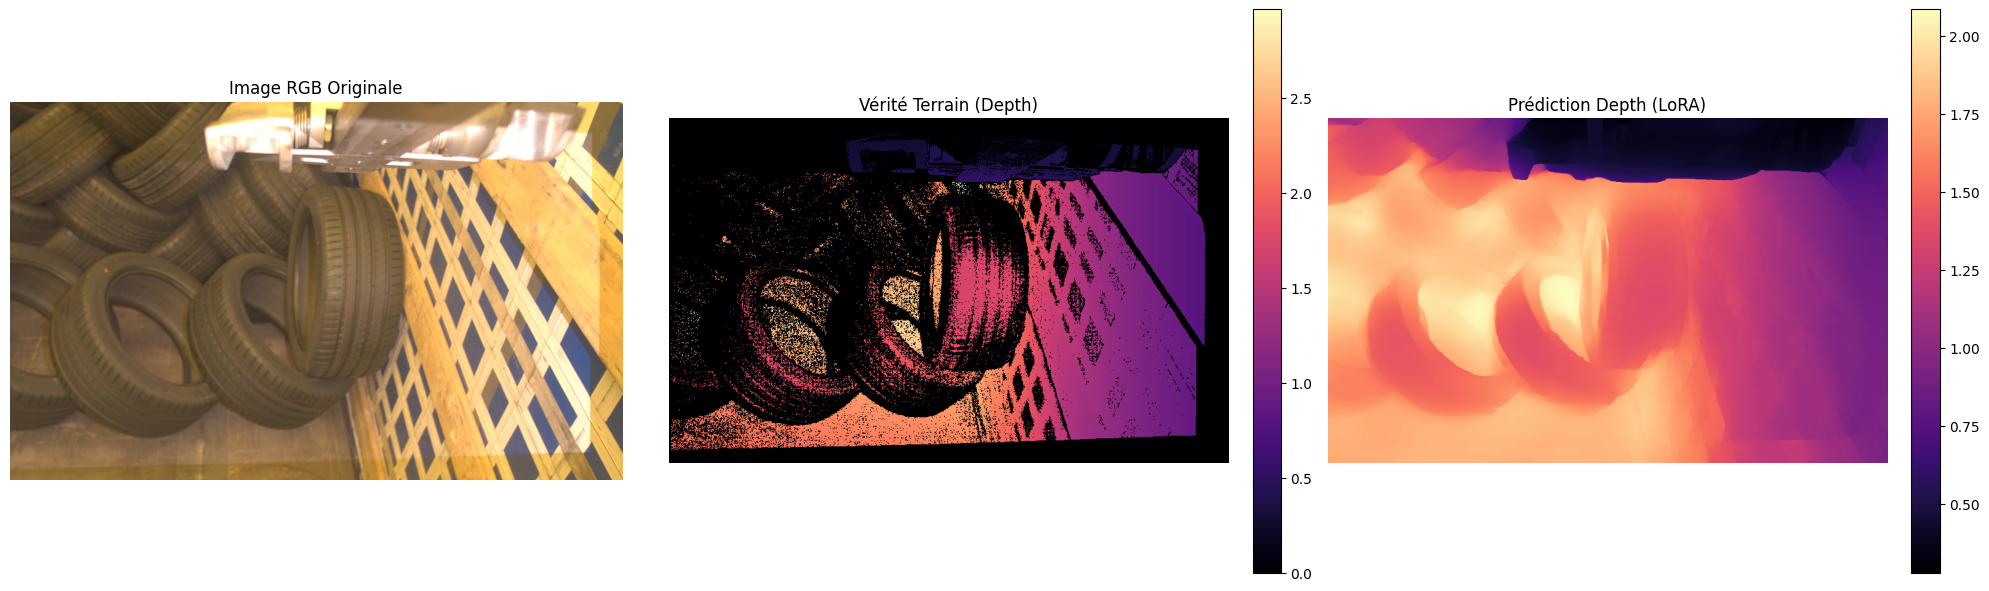

In [22]:
# --- NOUVELLE CELLULE À AJOUTER À LA FIN ---
import matplotlib.pyplot as plt
import torch
import numpy as np

# Mettre le modèle en mode évaluation pour désactiver le dropout, etc.
lora_model.eval()

# Sélectionner un index aléatoire dans le jeu de test
idx = random.randint(0, len(test_dataset) - 1)
sample = test_dataset[idx]

# Récupérer les données
# 'image' est l'image PIL originale (stockée dans votre __getitem__ personnalisé)
original_image = sample['image']
# 'labels' est la depth map pré-traitée (redimensionnée pour le modèle)
ground_truth = sample['labels'].cpu().numpy()
# Préparer l'input pour le modèle (ajouter la dimension de batch)
pixel_values = sample['pixel_values'].unsqueeze(0)

# Déplacer sur le GPU si disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pixel_values = pixel_values.to(device)
lora_model.to(device)

# Inférence sans calcul de gradients
with torch.no_grad():
    outputs = lora_model(pixel_values)
    predicted_depth = outputs.predicted_depth

    # Interpolation pour faire correspondre la prédiction à la taille du label (si nécessaire)
    # Les labels sortant du Dataset sont déjà redimensionnés à la taille d'entrée du modèle (ex: 518x518)
    prediction = torch.nn.functional.interpolate(
        predicted_depth.unsqueeze(1),
        size=ground_truth.shape,
        mode="bicubic",
        align_corners=False,
    ).squeeze().cpu().numpy()

# Visualisation
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# 1. Image RGB
axes[0].imshow(original_image)
axes[0].set_title("Image RGB Originale")
axes[0].axis("off")

# 2. Vérité Terrain (Ground Truth)
# On utilise une colormap 'magma' ou 'inferno' souvent utilisée pour la profondeur
im1 = axes[1].imshow(ground_truth, cmap='magma')
axes[1].set_title("Vérité Terrain (Depth)")
axes[1].axis("off")
plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

# 3. Prédiction du modèle LoRA
im2 = axes[2].imshow(prediction, cmap='magma')
axes[2].set_title("Prédiction Depth (LoRA)")
axes[2].axis("off")
plt.colorbar(im2, ax=axes[2], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

In [14]:
# Lancer l'évaluation sur le dataset de test
test_metrics = trainer.evaluate(eval_dataset=test_dataset)

# Afficher les résultats
print("Résultats sur le Test Set :")
print(test_metrics)

Résultats sur le Test Set :
{'eval_loss': 0.24545423686504364, 'eval_delta1': 0.9112081162741116, 'eval_delta2': 0.9684790169505396, 'eval_delta3': 0.9987337165204769, 'eval_abs_rel': 0.10097143799066544, 'eval_rmse': 0.24326473474502563, 'eval_runtime': 1.9908, 'eval_samples_per_second': 4.521, 'eval_steps_per_second': 1.005, 'epoch': 30.0}
